# Import useful stuff

In [35]:
# interactive plots in Jupyter, used to show plots inline in the notebook
%matplotlib inline

# The igraph library
from igraph import *

# Numpy for enhanced math array management
import numpy as np

#Usata per calcolare il logaritmo
from math import log

# statistical tools (we only use ECDF)
from statsmodels.distributions.empirical_distribution import ECDF

# Mathematical plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# use to control whether to show the entire cell output or only the last_expr (default)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# to generate random numbers
from random import *

# to fit power law distributions
from powerlaw import *

# INTRODUZIONE
## Facebook (WOSN) is undirected network contains friendship data of Facebook users. 
### A node represents a user and an edge represents a friendship between two users.

# Parameters

In [68]:
#Select the dataset
#dataset="./facebook.ncol"
#dataset="./node.ncol"
#dataset="./dataset/socfb-wosn-friends.cut.edges        #BIGGEST
#dataset="./dataset/socfb-wosn-friends.cut.sb.43K.edges #MEDIUM
dataset="./dataset/socfb-wosn-friends.cut.sb.10K.edges"

#Select if the dataset is directed or undirected
#direct=True
direct=False

#Select if connection-mode is weak or or strong
#This is the way to find Giant component
conn_mode="WEAK"
#conn_mode="STRONG"

# Creating and manipulating graphs
## Reading graphs from files & data frames / Writing graphs to files

In [69]:
file_graph = read(dataset, format = "ncol", directed = direct)
summary(file_graph, verbosity=1, max_rows = 25, edge_list_format = 'edgelist')

IGRAPH UN-- 10000 229693 -- 
+ attr: name (v)
+ edges (vertex names):
        edge  
[0]    5--22  
[1]    5--683 
[2]    5--821 
[3]    5--469 
[4]    5--639 
[5]    5--814 
[6]    5--1528
[7]    5--1640
[8]    5--1642
[9]    5--1643
[10]   5--1648
[11]   5--2548
[12]   5--4246
[13]   5--4503
[14]   5--4964
[15]   9--23  
[16]   9--2058
[17]   9--309 
[18]   9--2175
[19]   469--9 
[20]   639--9 
[21]   1528--9
[22]   1640--9
[23]   9--47  
[24]   9--100 


# Punto 3.a)
### Il Giant Component esiste?

In [70]:
# Check whether the graph is connected or not
if file_graph.is_connected(mode = "STRONG")==True:
    print ("The graph is STRONGLY CONNECTED. \n\nNodes are mutally connected. All Graph is the Giant Component")
    giant_component=file_graph
elif file_graph.is_connected(mode = "WEAK")==True:
    print ("The graph is WEAKLY CONNECTED. \n\nNodes are connected. All Graph is the Giant Component")
    giant_component=file_graph
else:
    print ("The graph is NOT CONNECTED. \n\nIt is necessary to find the Giant Component")    
    # Compute the connected components in the graph
    #   - "WEAK" does not consider the direction of edges
    #All clusters
    clusters_list = file_graph.clusters(mode = conn_mode)
    # the number of clusters
    print ("Number of clusters: ",len(clusters_list))    
    # the membership of vertices in the clusters. Every pos has the cluster_ID associated to the vertex
    #clusters_list.membership[0:10]
    # the sizes of the clusters
    #print ("Clusters size:")
    #clusters_list.sizes()[0:10]

    #Does Giant COmponent exist? 
    #GC esiste se contiene una frazione >> di nodi rispetto a logN (N =numero totale di nodi nel grafo), 
    #Gli altri componenti sono nell’ordine di logN

    
    #Trashold
    trashold=10*log(file_graph.vcount(),10)
    print ("Trashold is:", trashold)
    
    
    # sizes (sorted, first 20 elements)
    sorted_clusters = sorted(clusters_list.sizes(), reverse=True)
    print("Lista dei cluster ordinata per dimensione:")
    sorted_clusters[0:19]
    
    
    #bigger_cluster=max(clusters_list.sizes())
    print ("Bigger Cluster:", sorted_clusters[0])
    print ("2nd Bigger Cluster:", sorted_clusters[1])
    
    if sorted_clusters[0] > trashold and sorted_clusters[1] < trashold:
        print ("GIANT COMPONENT EXIST!!!")
    
        #Select the Giant Componet (the biggest cluster)
        giant_component = clusters_list.giant()
    
        # number of vertices and edges in the original graph
        print ("Numero di nodi del giant componet ", giant_component.vcount())
        print ("Numero di nodi totali ", file_graph.vcount())
        print ("GC: ",giant_component.vcount()*100/file_graph.vcount(),"%")
    
        #From this time we consider GC as the only one cluster 
        #file_graph=giant_component
    else :
        print ("GIANT COMPONENT DOES NOT EXIST!!!")
        exit(0)



The graph is STRONGLY CONNECTED. 

Nodes are mutally connected. All Graph is the Giant Component


### Graph of major nodes (degree > 100)

In [71]:
# Select only nodes with degree > 100 from the Giant Component
vertex_sequence = giant_component.vs.select(_degree_gt = 100)
giant_component_subgraph = giant_component.induced_subgraph(vertex_sequence)

try:
    del visual_style
    visual_style = {}
except NameError:
    visual_style = {}
    
visual_style["bbox"] = (600,600)
visual_style["label"] = []
visual_style["layout"] = giant_component_subgraph.layout_fruchterman_reingold()
visual_style["vertex_size"] = 5
visual_style["vertex_color"] = 'red'
visual_style["vertex_shape"] = 'circle'
visual_style["edge_arrow_size"] = 0.2
visual_style["edge_width"] = np.array(giant_component_subgraph.es["weight"])/10

plot(giant_component_subgraph, **visual_style)

KeyError: 'Attribute does not exist'

# Punto 3.b) Distribution Degree

In [48]:
# degree() method
# - mode = "ALL" to consider the undirected graph
degree_sequnce = giant_component.degree(mode = "all")
#degree_sequnce[0:19]

# the maximum degree, and the ID of the node with maximum degree
print ("Degree MASSIMO:", max(degree_sequnce))
id_max = np.argmax(degree_sequnce)
print ("ID of the node with max degree: ",id_max)
print ("Degree MINIMO:", min(degree_sequnce))
print ("Grado medio: ",mean(degree_sequnce))




"""
# the set of neighbours of the node with max degree
# - NB: in case of bidirectional links, the same neighbour is counted twice if mode = 'all'
neighbours_of_major_node = giant_component.neighbors(id_max, mode="all")
neighbours_of_major_node[0:19]
len(neighbour_list_of_major_node)

# the set of nodes reachable from id_max with AT MOST 1 jump
neighbours_order_1 = giant_component.neighborhood(id_max, order = 1, mode="all")
neighbours_order_1[0:19]

# the number of such nodes
# - NB: it also includes the node id_max itself (which is reachable with 0 jumps)
# - thus, the number of nodes reachable with one jump is this - 1
len(neighbours_order_1)
giant_component.neighborhood_size(id_max, order = 1, mode="all")
"""

Degree MASSIMO: 1098
ID of the node with max degree:  492
Degree MINIMO: 1
Grado medio:  45.93859999999997


'\n# the set of neighbours of the node with max degree\n# - NB: in case of bidirectional links, the same neighbour is counted twice if mode = \'all\'\nneighbours_of_major_node = giant_component.neighbors(id_max, mode="all")\nneighbours_of_major_node[0:19]\nlen(neighbour_list_of_major_node)\n\n# the set of nodes reachable from id_max with AT MOST 1 jump\nneighbours_order_1 = giant_component.neighborhood(id_max, order = 1, mode="all")\nneighbours_order_1[0:19]\n\n# the number of such nodes\n# - NB: it also includes the node id_max itself (which is reachable with 0 jumps)\n# - thus, the number of nodes reachable with one jump is this - 1\nlen(neighbours_order_1)\ngiant_component.neighborhood_size(id_max, order = 1, mode="all")\n'

__Note__

Why is the output of $\tt{neighbourhood\_size()}$ different from the length of $\tt{nei}$?

- consider that we used a __directed__ graph, and think what does it means in terms of degree and neighbours

Let's redo the same on the equivalent __undirected__ graph

In [50]:
"""# take the undirected version of the Giant Component 
# combine_edges tells what to do with the weights (default, lost attribute; here: sum values)
giant_component_undir = giant_component.as_undirected(combine_edges = "sum")

# Note the lower number of edges with respect to the directed version.
# This is because igraph automatically simplifies the graph (i.e., merges edges between the same nodes)
# to do so manually on a multi-edge graph: g.simplify()
# to check if the graph is simple or not: g.is_simple()
summary(giant_component_undir, verbosity = 1, edge_list_format = "edgelist", max_rows = 25)

# the maximum degree, and the ID of the node with maximum degree
degree_sequence_undir = giant_component_undir.degree()
max(degree_sequence_undir)
id_max_u = np.argmax(degree_sequence_undir)
id_max_u

# the set of neighbours of the node with max degree
neighbours_of_major_node_undir = giant_component_undir.neighbors(id_max_u)
len(neighbours_of_major_node_undir)

# the set of nodes reachable from id_max with AT MOST 1 jump
neighbours_order_1 = giant_component_undir.neighborhood(id_max, order = 1, mode="all")
neighbours_order_1[0:19]

# the number of such nodes
# - NB: it also includes the node id_max itself (which is reachable with 0 jumps)
# - thus, the number of nodes reachable with one jump is this - 1
len(neighbours_order_1)
giant_component_undir.neighborhood_size(id_max, order = 1, mode="all")
"""

'# take the undirected version of the Giant Component \n# combine_edges tells what to do with the weights (default, lost attribute; here: sum values)\ngiant_component_undir = giant_component.as_undirected(combine_edges = "sum")\n\n# Note the lower number of edges with respect to the directed version.\n# This is because igraph automatically simplifies the graph (i.e., merges edges between the same nodes)\n# to do so manually on a multi-edge graph: g.simplify()\n# to check if the graph is simple or not: g.is_simple()\nsummary(giant_component_undir, verbosity = 1, edge_list_format = "edgelist", max_rows = 25)\n\n# the maximum degree, and the ID of the node with maximum degree\ndegree_sequence_undir = giant_component_undir.degree()\nmax(degree_sequence_undir)\nid_max_u = np.argmax(degree_sequence_undir)\nid_max_u\n\n# the set of neighbours of the node with max degree\nneighbours_of_major_node_undir = giant_component_undir.neighbors(id_max_u)\nlen(neighbours_of_major_node_undir)\n\n# the se

### Degree density and CCDF

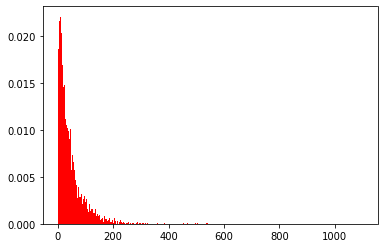

In [53]:
dd_h, dd_h_bins, _ = plt.hist(degree_sequnce, bins=range(1,max(degree_sequnce)+2), density=True, color = 'red')

Text(0.5, 0, 'd')

Text(0, 0.5, 'P(Degree = d)')

Text(0.5, 1.0, 'Degree density on a log-log scale')

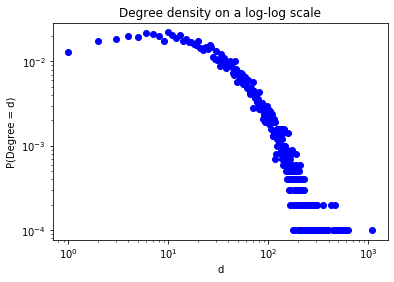

In [54]:
# Degree density on a loglog scale
plt.loglog(dd_h_bins[:-1], dd_h, 'bo')
plt.xlabel("d")
plt.ylabel("P(Degree = d)")
plt.title("Degree density on a log-log scale")

[0, 400, 0, 1]

Text(0.5, 0, 'd')

Text(0, 0.5, 'CCDF(Degree > d)')

Text(0.5, 1.0, 'CCDF primo metodo')

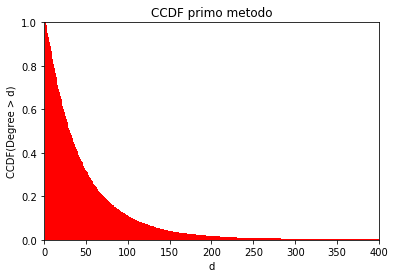

In [59]:
# Compute the CCDF - we can use 2 ways
# 1. use the histogram functions with parameter cumulative=-1 gives the CCDF
dd_h, dd_h_bins, _ = plt.hist(degree_sequnce, bins=range(1,max(degree_sequnce)+2), density = True, color = 'red', cumulative = -1)
plt.axis([0,400,0,1])
plt.xlabel("d")
plt.ylabel("CCDF(Degree > d)")
plt.title("CCDF primo metodo")

Text(0.5, 0, '$d$')

Text(0, 0.5, '$P(D>d)$')

Text(0.5, 1.0, 'Degree CCDF in a lin-lin scale')

Text(0.5, 0, '$d$')

Text(0, 0.5, '$P(D>d)$')

Text(0.5, 1.0, 'Degree CCDF in a log-log scale')

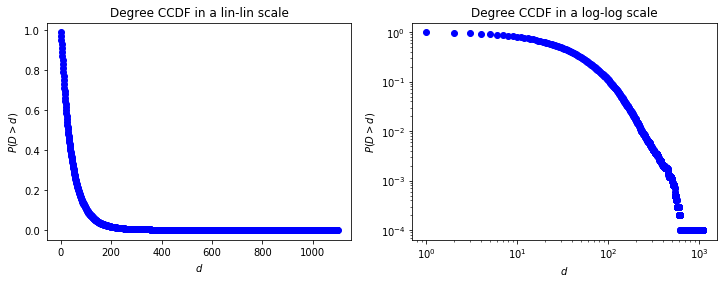

In [61]:
# 2. More general: use the ECDF function of statsmodels.distributions.empirical_distribution
# ECDF(dataset) returns a the empirical CDF computed from the dataset, which can be used as a FUNCTION
# - i.e., it is possible to call ECDF(x) for any x, irrespective of the set of data from which the ECDF is derived
deg_cdf = ECDF(degree_sequnce)

# scale the fig size twice in length
default_sizes = plt.rcParams["figure.figsize"]
fig_sizes = (2*default_sizes[0], default_sizes[1])

# generate a figure with 2 subplots, organised in 1 row and 2 columns
# ax1 and ax2 ("axes") are used to access the individual plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = fig_sizes)

# plot the CCDF in lin-lin and log-log scales
# see http://matplotlib.org/api/axes_api.html for the API of the Axis class
# see http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot or the Axes.plot() documentation
# for the parameters of the plot method
degs = np.arange(1,max(degree_sequnce)+1)

ax1.plot(degs, 1-deg_cdf(degs), 'bo')
ax1.set_xlabel("$d$")
ax1.set_ylabel("$P(D>d)$")
ax1.set_title("Degree CCDF in a lin-lin scale")

ax2.loglog(degs, 1-deg_cdf(degs), 'bo')
ax2.set_xlabel("$d$")
ax2.set_ylabel("$P(D>d)$")
ax2.set_title("Degree CCDF in a log-log scale")

### Random graphs - Erdős–Rényi model

Il GC del modello di Erdos Renyl ha un numero di nodi  10000  minore o uguale del nostro grafo 10000


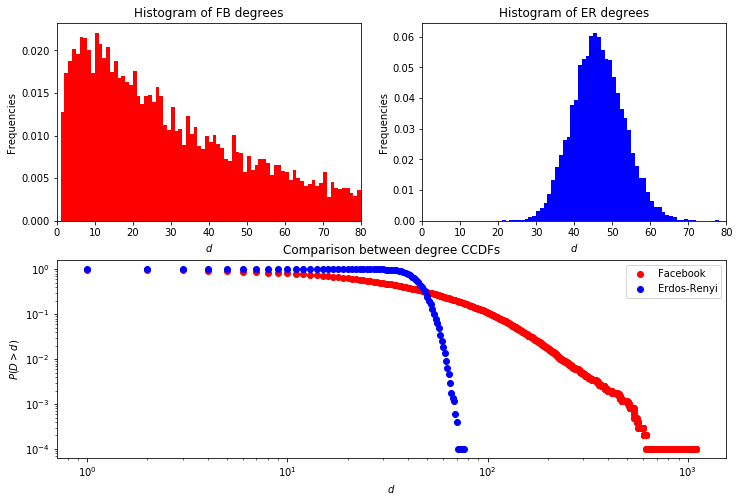

In [67]:
# Now we compare the degree distributions for the complete Giant Component
er_p_GC = mean(giant_component_undir.degree())/giant_component_undir.vcount()
er_fb_all = Graph.Erdos_Renyi(giant_component_undir.vcount(), er_p_GC)

# take only the Giant Component
er_fb = er_fb_all.clusters(mode = "WEAK").giant()
print ("Il GC del modello di Erdos Renyl ha un numero di nodi ",er_fb.vcount()," minore o uguale del nostro grafo", giant_component_undir.vcount())

# we use GridSpecs for a finer control of the plot positioning
fig_sizes = (fig_sizes[0], 2*default_sizes[1])
f = plt.figure(figsize = fig_sizes)

# create a 2x2 Grid Specification
gs = gridspec.GridSpec(2, 2)

# add subplots to the figure, using the GridSpec gs
# position [0,0] (upper-left corner)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
# the third plot spans the entire second row
ax3 = plt.subplot(gs[1,:])

# compute and plot the histogram of FB degrees
d_fb = giant_component_undir.degree()
_,_,_ = ax1.hist(d_fb, bins=range(1,max(d_fb)+2), density = True, color = 'red')
_ = ax1.set_xlim(0,80)
_ = ax1.set_xlabel("$d$")
_ = ax1.set_ylabel("Frequencies")
_ = ax1.set_title("Histogram of FB degrees")

# compute and plot the histogram of ER degrees
d_er = er_fb.degree()
_,_,_ = ax2.hist(d_er, bins=range(1,max(d_er)+2), density = True, color = 'blue')
_ = ax2.set_xlim(0,80)
_ = ax2.set_xlabel("$d$")
_ = ax2.set_ylabel("Frequencies")
_ = ax2.set_title("Histogram of ER degrees")

# compute and plot the degree CCDFs
fb_ecdf = ECDF(d_fb)
er_ecdf = ECDF(d_er)
x = np.arange(1,max(d_fb)+1)
_ = ax3.loglog(x, 1-fb_ecdf(x), 'ro', label = 'Facebook')
x = np.arange(1,max(d_er)+1)
_ = ax3.loglog(x, 1-er_ecdf(x), 'bo', label = 'Erdos-Renyi')
_ = ax3.set_xlabel("$d$")
_ = ax3.set_ylabel("$P(D>d)$")
_ = ax3.set_title("Comparison between degree CCDFs")
_ = ax3.legend(numpoints = 1)